In [ ]:
#MAPS FOR TEMPERATURE AND RELATIVE HUMIDITY
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.colors import Normalize

# Load the NetCDF file
nc_file = '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5_ReanalysisData/AverageMonths/AverageMonths_Updated.nc'
ds = xr.open_dataset(nc_file)

# Extract relevant variables
temperature = ds['WS'] 
relative_humidity = ds['RH']  
time = ds['time']
latitude = ds['latitude']
longitude = ds['longitude']

# Define the months of interest and their indices
months = ['May', 'June', 'July', 'August', 'September']
month_indices = [5, 6, 7, 8, 9]

# Calculate monthly averages over the years for the specified months
monthly_avg_temperature = temperature.groupby('time.month').mean(dim='time')
monthly_avg_relative_humidity = relative_humidity.groupby('time.month').mean(dim='time')

# Cap relative humidity values at 100%
#monthly_avg_relative_humidity = monthly_avg_relative_humidity.where(monthly_avg_relative_humidity <= 100, 100)

# Function to plot geographical maps for a specific region with color scale control
def plot_geographical_map(data, title, lon_range, lat_range, vmin, vmax, month_names, units, save_path_prefix):
    fig, axs = plt.subplots(2, 3, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    fig.suptitle(title, fontsize=16)
    axs = axs.flatten()
    
    # Use the same normalization for both plots
    norm = Normalize(vmin=vmin, vmax=vmax)
    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Add axes for color bar
    
    for i, (month, ax) in enumerate(zip(month_names, axs)):
        ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
        
        if month in month_names:
            data_month = data.sel(month=month_indices[i])
            im = ax.contourf(longitude, latitude, data_month, transform=ccrs.PlateCarree(), cmap='jet', norm=norm)
            ax.set_title(month)
            
            # Add latitude and longitude labels for September without gridlines
            if month == 'September':
                ax.set_xticks(np.arange(lon_range[0], lon_range[1]+10, 10), crs=ccrs.PlateCarree())
                ax.set_yticks(np.arange(lat_range[0], lat_range[1]+10, 10), crs=ccrs.PlateCarree())
                ax.xaxis.set_major_formatter(LongitudeFormatter())
                ax.yaxis.set_major_formatter(LatitudeFormatter())
                
                # Ensure labels are horizontal
                ax.tick_params(axis='x', rotation=0)
                ax.tick_params(axis='y', rotation=0)
                
                ax.gridlines(draw_labels=False, linestyle='--', linewidth=0)
                
        else:
            ax.axis('off')
    
    cbar = plt.colorbar(im, cax=cbar_ax, orientation='vertical')
    cbar.set_label(units)
    
    plt.tight_layout(rect=[0, 0, 0.9, 0.96])
    plt.savefig(f'{save_path_prefix}.png', dpi=300)
    plt.show()

# Convert temperature from Kelvin to Celsius
monthly_avg_temperature_celsius = monthly_avg_temperature #- 273.15

# Define the longitude and latitude ranges for your region of interest
lon_range = [20, 60]  # Example: longitude range
lat_range = [10, 50]  # Example: latitude range

# Define vmin and vmax for the color scale control
vmin_temp = -2.0  # Adjust based on your data range
vmax_temp = 12  # Adjust based on your data range

# Plot temperature maps for the specified region with color scale control
plot_geographical_map(monthly_avg_temperature_celsius, 'Average Monthly Windspeed (1980-2023)', lon_range, lat_range, vmin=vmin_temp, vmax=vmax_temp, month_names=months, units='Temperature (°C)', save_path_prefix='average_temperature')

# Define vmin and vmax for relative humidity
vmin_rh = 0  # Minimum value for relative humidity color scale
vmax_rh = 100  # Maximum value for relative humidity color scale

# Plot relative humidity maps for the specified region with color scale control
plot_geographical_map(monthly_avg_relative_humidity, 'Average Monthly Relative Humidity (1980-2023)', lon_range, lat_range, vmin=vmin_rh, vmax=vmax_rh, month_names=months, units='Relative Humidity (%)', save_path_prefix='average_relative_humidity')


In [ ]:
#MAPS FOR DI index
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

# Load the NetCDF file
nc_file = '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5_ReanalysisData/AverageMonths/AverageMonths_Updated.nc'
ds = xr.open_dataset(nc_file)

# Extract relevant variables
temperature = ds['T']  # Ensure the variable name matches your dataset
DI = ds['DI']  # Ensure the variable name matches your dataset
latitude = ds['latitude']
longitude = ds['longitude']
time = ds['time']

# Define the months of interest
months = [5, 6, 7, 8, 9]  # May, June, July, August, September

# Calculate monthly averages over the 43 years for temperature and DI
monthly_avg_temperature = temperature.sel(time=np.isin(time.dt.month, months)).groupby('time.month').mean(dim='time')
monthly_avg_DI = DI.sel(time=np.isin(time.dt.month, months)).groupby('time.month').mean(dim='time')

# Define color mapping based on temperature and DI values
def classify_values(temp, di):
    if temp < 293:
        return 0
    elif temp >= 293 and di < 21:
        return 1
    elif temp >= 293 and 21 <= di < 24:
        return 2
    elif temp >= 293 and 24 <= di < 27:
        return 3
    elif temp >= 293 and 27 <= di < 29:
        return 4
    elif temp >= 293 and 29 <= di < 32:
        return 5
    elif temp >= 293 and di >= 32:
        return 6
    else:
        return 0  # Default case to handle unexpected values

# Apply classification to the data
classified_data = np.zeros((latitude.size, longitude.size, len(months)), dtype=int)

for idx, month in enumerate(months):
    temp = monthly_avg_temperature.sel(month=month).values
    di = monthly_avg_DI.sel(month=month).values
    for i in range(temp.shape[0]):
        for j in range(temp.shape[1]):
            if np.isnan(temp[i, j]) or np.isnan(di[i, j]):
                classified_data[i, j, idx] = 0  # Set to gray if there's missing data
            else:
                try:
                    classified_data[i, j, idx] = classify_values(temp[i, j], di[i, j])
                except TypeError as e:
                    print(f"TypeError at month {month}, lat index {i}, lon index {j}: temp={temp[i, j]}, di={di[i, j]}")
                    classified_data[i, j, idx] = 0  # Set to gray in case of error

# Define custom colormap and labels
colors = ['gray', 'green', 'orange', 'darkorange', 'red', 'mediumorchid', 'black']
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm([0, 1, 2, 3, 4, 5, 6, 7], cmap.N)
labels = ['Out of range', 'Neutral', 'Moderately warm', 'Warm', 'Hot', 'Very hot', 'Sweltering']

# Create a larger figure to save all maps in a single PNG file
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=0.3, wspace=0.2)
axs = axs.flatten()

# Function to plot the map for a specific month
def plot_monthly_map(ax, month_idx, month_name):
    ax.set_extent([20, 60, 10, 50], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

    data = classified_data[:, :, month_idx]
    im = ax.pcolormesh(longitude, latitude, data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

    ax.set_title(f'{month_name}')
    return im

# Plot maps for each month of interest
for idx, month_name in enumerate(['May', 'June', 'July', 'August', 'September']):
    im = plot_monthly_map(axs[idx], idx, month_name)

# Hide the extra subplot (the 6th one)
axs[-1].axis('off')

# Add a colorbar with labels
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Position of the colorbar
cbar = fig.colorbar(im, cax=cbar_ax, ticks=np.arange(0.5, 7.5, 1))
cbar.ax.set_yticklabels(labels)

# Save the figure as a PNG file
plt.savefig('monthly_maps_DI.png', dpi=300)
plt.show()


In [ ]:
#MAPS FOR HI index
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

# Load the NetCDF file
nc_file = '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5_ReanalysisData/AverageMonths/AverageMonths_Updated.nc'
ds = xr.open_dataset(nc_file)

# Extract relevant variables
temperature = ds['T']  # Ensure the variable name matches your dataset
DI = ds['HI']  # Ensure the variable name matches your dataset
latitude = ds['latitude']
longitude = ds['longitude']
time = ds['time']

# Define the months of interest
months = [5, 6, 7, 8, 9]  # May, June, July, August, September

# Calculate monthly averages over the 43 years for temperature and DI
monthly_avg_temperature = temperature.sel(time=np.isin(time.dt.month, months)).groupby('time.month').mean(dim='time')
monthly_avg_DI = DI.sel(time=np.isin(time.dt.month, months)).groupby('time.month').mean(dim='time')

# Define color mapping based on temperature and DI values
def classify_values(temp, di):
    if temp < 293:
        return 0
    elif temp >= 293 and di < 27:
        return 1
    elif temp >= 293 and 27 <= di < 32:
        return 2
    elif temp >= 293 and 32 <= di < 41:
        return 3
    elif temp >= 293 and 41 <= di < 54:
        return 4
    elif temp >= 293 and di >= 54:
        return 5
    else:
        return 0  # Default case to handle unexpected values

# Apply classification to the data
classified_data = np.zeros((latitude.size, longitude.size, len(months)), dtype=int)

for idx, month in enumerate(months):
    temp = monthly_avg_temperature.sel(month=month).values
    di = monthly_avg_DI.sel(month=month).values
    for i in range(temp.shape[0]):
        for j in range(temp.shape[1]):
            if np.isnan(temp[i, j]) or np.isnan(di[i, j]):
                classified_data[i, j, idx] = 0  # Set to gray if there's missing data
            else:
                try:
                    classified_data[i, j, idx] = classify_values(temp[i, j], di[i, j])
                except TypeError as e:
                    print(f"TypeError at month {month}, lat index {i}, lon index {j}: temp={temp[i, j]}, di={di[i, j]}")
                    classified_data[i, j, idx] = 0  # Set to gray in case of error

# Define custom colormap and labels
colors = ['gray', 'gray', 'darkorange', 'red', 'mediumorchid', 'black']
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm([0, 1, 2, 3, 4, 5, 6], cmap.N)
labels = ['Out of range', 'Out of range', 'Warm', 'Hot', 'Very hot', 'Sweltering']

# Create a larger figure to save all maps in a single PNG file
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=0.3, wspace=0.2)
axs = axs.flatten()

# Function to plot the map for a specific month
def plot_monthly_map(ax, month_idx, month_name):
    ax.set_extent([20, 60, 10, 50], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

    data = classified_data[:, :, month_idx]
    im = ax.pcolormesh(longitude, latitude, data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

    ax.set_title(f'{month_name}')
    return im

# Plot maps for each month of interest
for idx, month_name in enumerate(['May', 'June', 'July', 'August', 'September']):
    im = plot_monthly_map(axs[idx], idx, month_name)

# Hide the extra subplot (the 6th one)
axs[-1].axis('off')

# Add a colorbar with labels
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Position of the colorbar
cbar = fig.colorbar(im, cax=cbar_ax, ticks=np.arange(0.5, 6.5, 1))
cbar.ax.set_yticklabels(labels)

# Save the figure as a PNG file
plt.savefig('monthly_maps_HI.png', dpi=300)
plt.show()

In [ ]:
#MAPS FOR HD index
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

# Load the NetCDF file
nc_file = '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5_ReanalysisData/AverageMonths/AverageMonths_Updated.nc'
ds = xr.open_dataset(nc_file)

# Extract relevant variables
temperature = ds['T']  # Ensure the variable name matches your dataset
DI = ds['HD']  # Ensure the variable name matches your dataset
latitude = ds['latitude']
longitude = ds['longitude']
time = ds['time']

# Define the months of interest
months = [5, 6, 7, 8, 9]  # May, June, July, August, September

# Calculate monthly averages over the 43 years for temperature and DI
monthly_avg_temperature = temperature.sel(time=np.isin(time.dt.month, months)).groupby('time.month').mean(dim='time')
monthly_avg_DI = DI.sel(time=np.isin(time.dt.month, months)).groupby('time.month').mean(dim='time')

# Define color mapping based on temperature and DI values
def classify_values(temp, di):
    if temp < 294:
        return 0
    elif temp >= 294 and di < 30:
        return 1
    elif temp >= 294 and 30 <= di < 40:
        return 2
    elif temp >= 294 and 40 <= di < 45:
        return 3
    elif temp >= 294 and 45 <= di < 55:
        return 4
    elif temp >= 294 and di >= 55:
        return 5
    else:
        return 0  # Default case to handle unexpected values

# Apply classification to the data
classified_data = np.zeros((latitude.size, longitude.size, len(months)), dtype=int)

for idx, month in enumerate(months):
    temp = monthly_avg_temperature.sel(month=month).values
    di = monthly_avg_DI.sel(month=month).values
    for i in range(temp.shape[0]):
        for j in range(temp.shape[1]):
            if np.isnan(temp[i, j]) or np.isnan(di[i, j]):
                classified_data[i, j, idx] = 0  # Set to gray if there's missing data
            else:
                try:
                    classified_data[i, j, idx] = classify_values(temp[i, j], di[i, j])
                except TypeError as e:
                    print(f"TypeError at month {month}, lat index {i}, lon index {j}: temp={temp[i, j]}, di={di[i, j]}")
                    classified_data[i, j, idx] = 0  # Set to gray in case of error

# Define custom colormap and labels
colors = ['gray', 'green', 'darkorange', 'red', 'mediumorchid', 'black']
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm([0, 1, 2, 3, 4, 5, 6], cmap.N)
labels = ['Out of range', 'Neutral', 'Warm', 'Hot', 'Very hot', 'Sweltering']

# Create a larger figure to save all maps in a single PNG file
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=0.3, wspace=0.2)
axs = axs.flatten()

# Function to plot the map for a specific month
def plot_monthly_map(ax, month_idx, month_name):
    ax.set_extent([20, 60, 10, 50], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

    data = classified_data[:, :, month_idx]
    im = ax.pcolormesh(longitude, latitude, data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

    ax.set_title(f'{month_name}')
    return im

# Plot maps for each month of interest
for idx, month_name in enumerate(['May', 'June', 'July', 'August', 'September']):
    im = plot_monthly_map(axs[idx], idx, month_name)

# Hide the extra subplot (the 6th one)
axs[-1].axis('off')

# Add a colorbar with labels
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Position of the colorbar
cbar = fig.colorbar(im, cax=cbar_ax, ticks=np.arange(0.5, 6.5, 1))
cbar.ax.set_yticklabels(labels)

# Save the figure as a PNG file
plt.savefig('monthly_maps_HD.png', dpi=300)
plt.show()


In [ ]:
#MAPS FOR WBGT index
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

# Load the NetCDF file
nc_file = '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5_ReanalysisData/AverageMonths/AverageMonths_Updated.nc'
ds = xr.open_dataset(nc_file)

# Extract relevant variables
temperature = ds['T']  # Ensure the variable name matches your dataset
DI = ds['WBGT']  # Ensure the variable name matches your dataset
latitude = ds['latitude']
longitude = ds['longitude']
time = ds['time']

# Define the months of interest
months = [5, 6, 7, 8, 9]  # May, June, July, August, September

# Calculate monthly averages over the 43 years for temperature and DI
monthly_avg_temperature = temperature.sel(time=np.isin(time.dt.month, months)).groupby('time.month').mean(dim='time')
monthly_avg_DI = DI.sel(time=np.isin(time.dt.month, months)).groupby('time.month').mean(dim='time')

# Define color mapping based on temperature and DI values
def classify_values(temp, di):
    if temp < 283:
        return 0
    elif temp >= 283 and di < 18:
        return 1
    elif temp >= 283 and 18 <= di < 24:
        return 2
    elif temp >= 283 and 24 <= di < 28:
        return 3
    elif temp >= 283 and 28 <= di < 30:
        return 4
    elif temp >= 283 and di >= 30:
        return 5
    else:
        return 0  # Default case to handle unexpected values

# Apply classification to the data
classified_data = np.zeros((latitude.size, longitude.size, len(months)), dtype=int)

for idx, month in enumerate(months):
    temp = monthly_avg_temperature.sel(month=month).values
    di = monthly_avg_DI.sel(month=month).values
    for i in range(temp.shape[0]):
        for j in range(temp.shape[1]):
            if np.isnan(temp[i, j]) or np.isnan(di[i, j]):
                classified_data[i, j, idx] = 0  # Set to gray if there's missing data
            else:
                try:
                    classified_data[i, j, idx] = classify_values(temp[i, j], di[i, j])
                except TypeError as e:
                    print(f"TypeError at month {month}, lat index {i}, lon index {j}: temp={temp[i, j]}, di={di[i, j]}")
                    classified_data[i, j, idx] = 0  # Set to gray in case of error

# Define custom colormap and labels
colors = ['gray', 'green', 'darkorange', 'red', 'mediumorchid', 'black']
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm([0, 1, 2, 3, 4, 5, 6], cmap.N)
labels = ['Out of range', 'Neutral', 'Warm', 'Hot', 'Very hot', 'Sweltering']

# Create a larger figure to save all maps in a single PNG file
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=0.3, wspace=0.2)
axs = axs.flatten()

# Function to plot the map for a specific month
def plot_monthly_map(ax, month_idx, month_name):
    ax.set_extent([20, 60, 10, 50], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

    data = classified_data[:, :, month_idx]
    im = ax.pcolormesh(longitude, latitude, data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

    ax.set_title(f'{month_name}')
    return im

# Plot maps for each month of interest
for idx, month_name in enumerate(['May', 'June', 'July', 'August', 'September']):
    im = plot_monthly_map(axs[idx], idx, month_name)

# Hide the extra subplot (the 6th one)
axs[-1].axis('off')

# Add a colorbar with labels
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Position of the colorbar
cbar = fig.colorbar(im, cax=cbar_ax, ticks=np.arange(0.5, 6.5, 1))
cbar.ax.set_yticklabels(labels)

# Save the figure as a PNG file
plt.savefig('monthly_maps_WBGT.png', dpi=300)
plt.show()


In [ ]:
#MAPS FOR ET index
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

# Load the NetCDF file
nc_file = '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5_ReanalysisData/AverageMonths/AverageMonths_Updated.nc'
ds = xr.open_dataset(nc_file)

# Extract relevant variables
temperature = ds['T']  # Ensure the variable name matches your dataset
DI = ds['ET']  # Ensure the variable name matches your dataset
latitude = ds['latitude']
longitude = ds['longitude']
time = ds['time']

# Define the months of interest
months = [5, 6, 7, 8, 9]  # May, June, July, August, September

# Calculate monthly averages over the 43 years for temperature and DI
monthly_avg_temperature = temperature.sel(time=np.isin(time.dt.month, months)).groupby('time.month').mean(dim='time')
monthly_avg_DI = DI.sel(time=np.isin(time.dt.month, months)).groupby('time.month').mean(dim='time')

# Define color mapping based on temperature and DI values
def classify_values(temp, di):
    if temp < 274:
        return 0
    elif temp >= 274 and di < 1:
        return 1
    elif temp >= 274 and 1 <= di < 9:
        return 2
    elif temp >= 274 and 9 <= di < 17:
        return 3
    elif temp >= 274 and 17 <= di < 21:
        return 4
    elif temp >= 274 and 21 <= di < 23:
        return 5
    elif temp >= 274 and 23 <= di < 27:
        return 6
    elif temp >= 274 and di >= 27:
        return 7
    else:
        return 0  # Default case to handle unexpected values

# Apply classification to the data
classified_data = np.zeros((latitude.size, longitude.size, len(months)), dtype=int)

for idx, month in enumerate(months):
    temp = monthly_avg_temperature.sel(month=month).values
    di = monthly_avg_DI.sel(month=month).values
    for i in range(temp.shape[0]):
        for j in range(temp.shape[1]):
            if np.isnan(temp[i, j]) or np.isnan(di[i, j]):
                classified_data[i, j, idx] = 0  # Set to gray if there's missing data
            else:
                try:
                    classified_data[i, j, idx] = classify_values(temp[i, j], di[i, j])
                except TypeError as e:
                    print(f"TypeError at month {month}, lat index {i}, lon index {j}: temp={temp[i, j]}, di={di[i, j]}")
                    classified_data[i, j, idx] = 0  # Set to gray in case of error

# Define custom colormap and labels
colors = ['white', 'white', 'white','white', 'green', 'darkorange', 'red', 'mediumorchid'] #'gray', 'blue', 'cornflowerblue','lightblue', 'green', 'darkorange', 'red', 'mediumorchid'
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm([0, 1, 2, 3, 4, 5, 6, 7, 8], cmap.N)
labels = ['Out of range', 'Very cold','Cold', 'Cool', 'Neutral', 'Warm', 'Hot', 'Very hot']

# Create a larger figure to save all maps in a single PNG file
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=0.3, wspace=0.2)
axs = axs.flatten()

# Function to plot the map for a specific month
def plot_monthly_map(ax, month_idx, month_name):
    ax.set_extent([20, 60, 10, 50], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

    data = classified_data[:, :, month_idx]
    im = ax.pcolormesh(longitude, latitude, data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

    ax.set_title(f'{month_name}')
    return im

# Plot maps for each month of interest
for idx, month_name in enumerate(['May', 'June', 'July', 'August', 'September']):
    im = plot_monthly_map(axs[idx], idx, month_name)

# Hide the extra subplot (the 6th one)
axs[-1].axis('off')

# Add a colorbar with labels
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Position of the colorbar
cbar = fig.colorbar(im, cax=cbar_ax, ticks=np.arange(0.5, 7.5, 1))
cbar.ax.set_yticklabels(labels)

# Save the figure as a PNG file
plt.savefig('monthly_maps_ET.png', dpi=300)
plt.show()


In [ ]:
#REGRESSION MAPS FOR TEMPERATURE
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the NetCDF file
file_path = '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5_ReanalysisData/AverageMonths/AverageMonths_Updated.nc'
ds = xr.open_dataset(file_path)

# Convert temperature from Kelvin to Celsius
ds['T'] = ds['T'] - 273.15

# Define the known geographical coordinates
lat_bounds = (10, 50)  # From 10°N to 50°N
lon_bounds = (20, 60)  # From 20°E to 60°E

# Generate synthetic latitude and longitude coordinates
latitude = np.linspace(lat_bounds[0], lat_bounds[1], ds.dims['latitude'])
longitude = np.linspace(lon_bounds[0], lon_bounds[1], ds.dims['longitude'])

# Add synthetic coordinates to the dataset
ds = ds.assign_coords(latitude=latitude, longitude=longitude)

# Define seasons
seasons = {
    'winter': [12, 1, 2],
    'spring': [3, 4, 5],
    'summer': [6, 7, 8],
    'autumn': [9, 10, 11],
    'annual': list(range(1, 13))
}

# Function to calculate seasonal and annual temperature trends
def calculate_trends(ds):
    trends = {}
    for season, months in seasons.items():
        season_ds = ds.sel(time=ds['time.month'].isin(months))
        if season == 'winter':
            # Special handling for winter season spanning years
            season_ds = season_ds.resample(time='QS-DEC').mean()
        season_ds = season_ds.groupby('time.year').mean(dim='time')
        polyfit_results = season_ds.polyfit(dim='year', deg=1)
        trends[season] = polyfit_results['T_polyfit_coefficients'].sel(degree=1) * 10  # Decadal trend
    return trends

# Calculate temperature trends
trends = calculate_trends(ds)

# Function to plot geographical maps of temperature trends
def plot_trend_map(trends, season, ax):
    ax.set_extent([20, 60, 10, 50], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

    trend = trends[season]
    levels = [-2.5, -2.25, -2, -1.75, -1.5, -1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5]
    im = ax.contourf(longitude, latitude, trend,
                     transform=ccrs.PlateCarree(), cmap='bwr', levels=levels)
    ax.set_title(f'{season.capitalize()}')

    return im

# Create a single figure and axes vertically stacked
fig, axs = plt.subplots(len(seasons), 1, figsize=(8, 15), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle('Temperature Trend Maps')

# Plot maps for each season
ims = []
for i, season in enumerate(seasons.keys()):
    im = plot_trend_map(trends, season, axs[i])
    ims.append(im)

# Add a single color bar next to the subplots
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(ims[0], cax=cbar_ax, orientation='vertical')
cbar.set_label('Temperature Trend (°C/decade)')

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.savefig('temperature_trend_maps.png')
plt.show()


<ipython-input-12-f5ed18fae942>:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


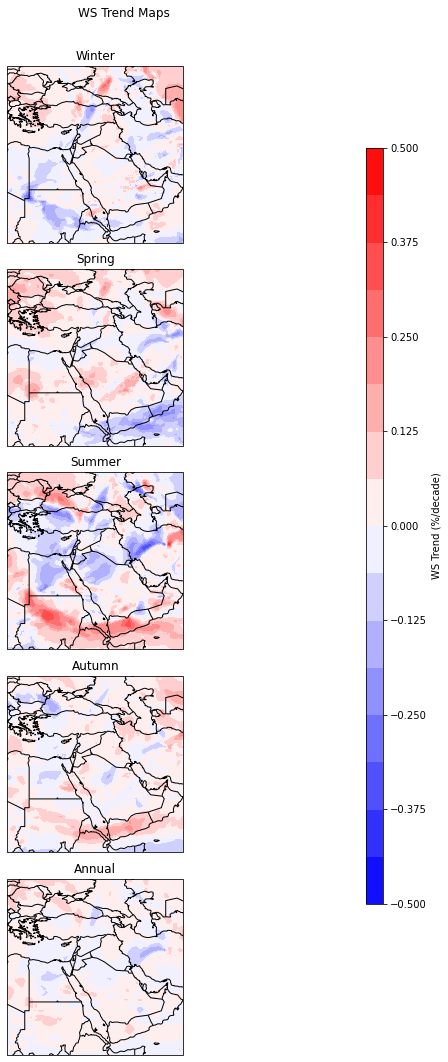

In [12]:
#REGRESSION MAPS FOR RH
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the NetCDF file
file_path = '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5_ReanalysisData/AverageMonths/AverageMonths_Updated.nc'
ds = xr.open_dataset(file_path)

# Convert temperature from Kelvin to Celsius
ds['WS'] = ds['WS']

# Define the known geographical coordinates
lat_bounds = (10, 50)  # From 10°N to 50°N
lon_bounds = (20, 60)  # From 20°E to 60°E

# Generate synthetic latitude and longitude coordinates
latitude = np.linspace(lat_bounds[0], lat_bounds[1], ds.dims['latitude'])
longitude = np.linspace(lon_bounds[0], lon_bounds[1], ds.dims['longitude'])

# Add synthetic coordinates to the dataset
ds = ds.assign_coords(latitude=latitude, longitude=longitude)

# Define seasons
seasons = {
    'winter': [12, 1, 2],
    'spring': [3, 4, 5],
    'summer': [6, 7, 8],
    'autumn': [9, 10, 11],
    'annual': list(range(1, 13))
}

# Function to calculate seasonal and annual temperature trends
def calculate_trends(ds):
    trends = {}
    for season, months in seasons.items():
        season_ds = ds.sel(time=ds['time.month'].isin(months))
        if season == 'winter':
            # Special handling for winter season spanning years
            season_ds = season_ds.resample(time='QS-DEC').mean()
        season_ds = season_ds.groupby('time.year').mean(dim='time')
        polyfit_results = season_ds.polyfit(dim='year', deg=1)
        trends[season] = polyfit_results['WS_polyfit_coefficients'].sel(degree=1) * 10  # Decadal trend
    return trends

# Calculate temperature trends
trends = calculate_trends(ds)

# Function to plot geographical maps of temperature trends
def plot_trend_map(trends, season, ax):
    ax.set_extent([20, 60, 10, 50], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

    trend = trends[season]
    #levels = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
    #levels=[-5, -4.5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2,  2.5, 3,  3.5,  4, 4.5, 5]
    levels=[  -0.5, -0.4375, -0.375, -0.3125, -0.25, -0.1875, -0.125, -0.0625, 0, 0.0625, 0.125, 0.1875, 0.25, 0.3125, 0.375, 0.4375, 0.5]
    im = ax.contourf(longitude, latitude, trend,
                     transform=ccrs.PlateCarree(), cmap='bwr', levels=levels)
    ax.set_title(f'{season.capitalize()}')

    return im

# Create a single figure and axes vertically stacked
fig, axs = plt.subplots(len(seasons), 1, figsize=(8, 15), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle('WS Trend Maps')

# Plot maps for each season
ims = []
for i, season in enumerate(seasons.keys()):
    im = plot_trend_map(trends, season, axs[i])
    ims.append(im)

# Add a single color bar next to the subplots
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(ims[0], cax=cbar_ax, orientation='vertical')
cbar.set_label('WS Trend (%/decade)')

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.savefig('WS_trend_maps.png')
plt.show()


In [ ]:
#REGRESSION MAPS FOR THE THERMAL INDICES AND WBT
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the NetCDF file
file_path = '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5_ReanalysisData/AverageMonths/WBT'
ds = xr.open_dataset(file_path)

# Convert temperature from Kelvin to Celsius
ds['Tw'] = ds['Tw']

# Define the known geographical coordinates
lat_bounds = (10, 50)  # From 10°N to 50°N
lon_bounds = (20, 60)  # From 20°E to 60°E

# Generate synthetic latitude and longitude coordinates
latitude = np.linspace(lat_bounds[0], lat_bounds[1], ds.dims['latitude'])
longitude = np.linspace(lon_bounds[0], lon_bounds[1], ds.dims['longitude'])

# Add synthetic coordinates to the dataset
ds = ds.assign_coords(latitude=latitude, longitude=longitude)

# Define seasons
seasons = {
    'winter': [12, 1, 2],
    'spring': [3, 4, 5],
    'summer': [6, 7, 8],
    'autumn': [9, 10, 11],
    'annual': list(range(1, 13))
}

# Function to calculate seasonal and annual temperature trends
def calculate_trends(ds):
    trends = {}
    for season, months in seasons.items():
        season_ds = ds.sel(time=ds['time.month'].isin(months))
        if season == 'winter':
            # Special handling for winter season spanning years
            season_ds = season_ds.resample(time='QS-DEC').mean()
        season_ds = season_ds.groupby('time.year').mean(dim='time')
        polyfit_results = season_ds.polyfit(dim='year', deg=1)
        trends[season] = polyfit_results['Tw_polyfit_coefficients'].sel(degree=1) * 10  # Decadal trend
    return trends

# Calculate temperature trends
trends = calculate_trends(ds)

# Function to plot geographical maps of temperature trends
def plot_trend_map(trends, season, ax):
    ax.set_extent([20, 60, 10, 50], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

    trend = trends[season]
    levels = [-2.5, -2.25, -2, -1.75, -1.5, -1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5]
    im = ax.contourf(longitude, latitude, trend,
                     transform=ccrs.PlateCarree(), cmap='bwr', levels=levels)
    ax.set_title(f'{season.capitalize()}')

    return im

# Create a single figure and axes vertically stacked
fig, axs = plt.subplots(len(seasons), 1, figsize=(8, 15), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle('WBT Trend Maps')

# Plot maps for each season
ims = []
for i, season in enumerate(seasons.keys()):
    im = plot_trend_map(trends, season, axs[i])
    ims.append(im)

# Add a single color bar next to the subplots
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(ims[0], cax=cbar_ax, orientation='vertical')
cbar.set_label('WBT Trend (°C/decade)')

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.savefig('WBT_trend_maps.png')
plt.show()


In [ ]:
#Average number of hours per day exceeding comfort for the entire summer months
#For the circle plots in the paper
import xarray as xr

# Load the NetCDF file
nc_file = '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5-UpdatedData/1992/AbuDhabi_updated.nc'
ds = xr.open_dataset(nc_file)

# Extract longitude, latitude, time, and DI variables
time = ds['time']
DI = ds['HI']

# Define the months of interest and their corresponding days
months = ['May', 'June', 'July', 'August', 'September']
days_in_month = [31, 30, 31, 31, 30]  # Number of days in each month

# Initialize a dictionary to store total hours above 27°C for each month
hours_above_27 = {month: 0 for month in months}

# Loop through each month
for month_idx, month in enumerate(months, start=5):  # Start at month index 5 for May
    # Select DI for the current month
    DI_month = DI[time.dt.month == month_idx]
    
    # Count hours where DI exceeds 27
    hours_above_27[month] = float((DI_month > 32).sum(dim='time'))

# Calculate average hours per day above 27°C for the summer season
avg_hours_per_day = sum(hours_above_27.values()) / sum(days_in_month)

# Print the results
for month in months:
    print(f"Total hours with ET > 32°C in {month}: {hours_above_27[month]} hours")

print(f"Average hours per day with ET > 32°C in summer: {avg_hours_per_day:.2f} hours")


In [ ]:
#number of discomfort hours per day averaged for 43 years for each summer month (May, June, July, August and September)
#for the bar charts in the paper
import xarray as xr
import pandas as pd
import subprocess 
# Load the NetCDF file
nc_file = '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5-UpdatedData/2023/Tehran_updated.nc'
ds = xr.open_dataset(nc_file)

# Extract time and thermal comfort indices variables
time = ds['time']
ET = ds['ET']
HI = ds['HI']
HD = ds['HD']
WBGT = ds['WBGT']
DI = ds['DI']

# Define the months of interest
months = ['May', 'June', 'July', 'August', 'September']

# Initialize dictionaries to store total hours above thresholds for each month
hours_above_ET = {month: 0 for month in months}
hours_above_HI = {month: 0 for month in months}
hours_above_HD = {month: 0 for month in months}
hours_above_WBGT = {month: 0 for month in months}
hours_above_DI = {month: 0 for month in months}

# Loop through each month
for month_idx, month in enumerate(months, start=5):  # Start at month index 5 for May
    # Select indices for the current month
    ET_month = ET[time.dt.month == month_idx]
    HI_month = HI[time.dt.month == month_idx]
    HD_month = HD[time.dt.month == month_idx]
    WBGT_month = WBGT[time.dt.month == month_idx]
    DI_month = DI[time.dt.month == month_idx]
    
    # Count hours where indices exceed their respective thresholds
    hours_above_ET[month] = float((ET_month > 23).sum(dim='time'))
    hours_above_HI[month] = float((HI_month > 32).sum(dim='time'))
    hours_above_HD[month] = float((HD_month > 40).sum(dim='time'))
    hours_above_WBGT[month] = float((WBGT_month > 24).sum(dim='time'))
    hours_above_DI[month] = float((DI_month > 27).sum(dim='time'))

# Create a DataFrame to store the results in a single row
results_df = pd.DataFrame([{
    'May_DI>27': hours_above_DI['May'],
    'June_DI>27': hours_above_DI['June'],
    'July_DI>27': hours_above_DI['July'],
    'August_DI>27': hours_above_DI['August'],
    'September_DI>27': hours_above_DI['September'],
    'May_ET>23': hours_above_ET['May'],
    'June_ET>23': hours_above_ET['June'],
    'July_ET>23': hours_above_ET['July'],
    'August_ET>23': hours_above_ET['August'],
    'September_ET>23': hours_above_ET['September'],
    'May_HI>32': hours_above_HI['May'],
    'June_HI>32': hours_above_HI['June'],
    'July_HI>32': hours_above_HI['July'],
    'August_HI>32': hours_above_HI['August'],
    'September_HI>32': hours_above_HI['September'],
    'May_HD>40': hours_above_HD['May'],
    'June_HD>40': hours_above_HD['June'],
    'July_HD>40': hours_above_HD['July'],
    'August_HD>40': hours_above_HD['August'],
    'September_HD>40': hours_above_HD['September'],
    'May_WBGT>24': hours_above_WBGT['May'],
    'June_WBGT>24': hours_above_WBGT['June'],
    'July_WBGT>24': hours_above_WBGT['July'],
    'August_WBGT>24': hours_above_WBGT['August'],
    'September_WBGT>24': hours_above_WBGT['September']
}])

# Save the results to an Excel sheet
output_file = 'thermal_comfort_indices_single_row.xlsx'
results_df.to_excel(output_file, index=False)

print(f"Results have been saved to {output_file}")
subprocess.call(['xdg-open', '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5-UpdatedData/thermal_comfort_indices_single_row.xlsx'])

In [ ]:
# NUMBER OF DAYS PER MONTH DURING WHICH THE INDICES EXCEEDS THE THRESHHOLD
#NOT USED
import xarray as xr
import numpy as np

# Load the NetCDF file
nc_file = '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5-UpdatedData/1980/Manama_updated.nc'
ds = xr.open_dataset(nc_file)

# Extract relevant variables
time = ds['time']
DI = ds['DI']
HI = ds['HI']
ET = ds['ET']
WBGT = ds['WBGT']
HD = ds['HD']

# Define thresholds for each parameter
thresholds = {
    'DI': 27,
    'ET': 23,
    'HD': 40,
    'WBGT': 24,
    'HI': 32  # Adjust this threshold as needed
}

# Define the months of interest
months = ['May', 'June', 'July', 'August', 'September']
month_indices = [5, 6, 7, 8, 9]

# Initialize a dictionary to store days exceeding thresholds
days_above_threshold = {month: {param: 0 for param in thresholds.keys()} for month in months}

# Function to count days exceeding the threshold
def count_days_exceeding_threshold(parameter, threshold, time):
    # Filter data for values exceeding the threshold
    exceeds_threshold = parameter > threshold
    
    # Group by day and check if any hour in the day exceeds the threshold
    exceeds_any_hour = exceeds_threshold.groupby(time.dt.floor('D')).any(dim='time')
    
    # Count the number of days where the threshold is exceeded
    days_exceeding = exceeds_any_hour.sum(dim='floor')
    
    return days_exceeding

# Loop through each month and calculate days exceeding thresholds for each parameter
for month, month_idx in zip(months, month_indices):
    # Select data for the current month
    month_data = ds.sel(time=ds['time.month'] == month_idx)
    
    # Count days exceeding thresholds for each parameter
    di_days = count_days_exceeding_threshold(month_data['DI'], thresholds['DI'], month_data['time'])
    et_days = count_days_exceeding_threshold(month_data['ET'], thresholds['ET'], month_data['time'])
    hd_days = count_days_exceeding_threshold(month_data['HD'], thresholds['HD'], month_data['time'])
    wbgt_days = count_days_exceeding_threshold(month_data['WBGT'], thresholds['WBGT'], month_data['time'])
    hi_days = count_days_exceeding_threshold(month_data['HI'], thresholds['HI'], month_data['time'])
    
    # Store results
    days_above_threshold[month]['DI'] = di_days.values
    days_above_threshold[month]['ET'] = et_days.values
    days_above_threshold[month]['HD'] = hd_days.values
    days_above_threshold[month]['WBGT'] = wbgt_days.values
    days_above_threshold[month]['HI'] = hi_days.values

# Calculate the average number of days per month during which indices exceed thresholds
average_days_per_month = {param: [] for param in thresholds.keys()}

for param in thresholds.keys():
    for month in months:
        average_days_per_month[param].append(np.mean(days_above_threshold[month][param]))

# Print the results
for param in thresholds.keys():
    print(f"Average number of days per month where {param} exceeds the threshold:")
    for month, avg_days in zip(months, average_days_per_month[param]):
        print(f"  {month}: {avg_days:.2f} days")

In [ ]:
#To get the numbers of %RH/decade
# ANNUAL
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import TwoSlopeNorm

# Load the NetCDF file
file_path = '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5_ReanalysisData/AverageMonths/AverageMonths_Updated.nc'
ds = xr.open_dataset(file_path)

# Define the known geographical coordinates
lat_bounds = (10, 50)  # From 10°N to 50°N
lon_bounds = (20, 60)  # From 20°E to 60°E

# Generate synthetic latitude and longitude coordinates
latitude = np.linspace(lat_bounds[0], lat_bounds[1], ds.dims['latitude'])
longitude = np.linspace(lon_bounds[0], lon_bounds[1], ds.dims['longitude'])

# Add synthetic coordinates to the dataset
ds = ds.assign_coords(latitude=latitude, longitude=longitude)

# Define seasons
seasons = {
    'winter': [12, 1, 2],
    'spring': [3, 4, 5],
    'summer': [6, 7, 8],
    'autumn': [9, 10, 11],
    'annual': list(range(1, 12))
}

# Function to calculate seasonal and annual trends
def calculate_trends(ds, variable):
    trends = {}
    for season, months in seasons.items():
        season_ds = ds.sel(time=ds['time.month'].isin(months))
        if season == 'winter':
            # Special handling for winter season spanning years
            season_ds = season_ds.resample(time='QS-DEC').mean()
        season_ds = season_ds.groupby('time.year').mean(dim='time')
        polyfit_results = season_ds.polyfit(dim='year', deg=1)
        trends[season] = polyfit_results[f'{variable}_polyfit_coefficients'].sel(degree=1) * 10  # Decadal trend
    return trends

# Calculate RH trends
rh_trends = calculate_trends(ds, 'RH')

# Create a new xarray.Dataset for saving the trends
trend_ds = xr.Dataset(
    {
        'RH_trend': (['latitude', 'longitude'], rh_trends['annual'].values)
    },
    coords={
        'latitude': latitude,
        'longitude': longitude
    }
)

# Save the dataset to a NetCDF file
trend_ds.to_netcdf('RH_trend_per_decade.nc')

In [ ]:
#To get the numbers of degree C/decade
#ANNUAL
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import TwoSlopeNorm

# Load the NetCDF file
file_path = '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5_ReanalysisData/AverageMonths/AverageMonths_Updated.nc'
ds = xr.open_dataset(file_path)

# Define the known geographical coordinates
lat_bounds = (10, 50)  # From 10°N to 50°N
lon_bounds = (20, 60)  # From 20°E to 60°E

# Generate synthetic latitude and longitude coordinates
latitude = np.linspace(lat_bounds[0], lat_bounds[1], ds.dims['latitude'])
longitude = np.linspace(lon_bounds[0], lon_bounds[1], ds.dims['longitude'])

# Add synthetic coordinates to the dataset
ds = ds.assign_coords(latitude=latitude, longitude=longitude)

# Define seasons
seasons = {
    'winter': [12, 1, 2],
    'spring': [3, 4, 5],
    'summer': [6, 7, 8],
    'autumn': [9, 10, 11],
    'annual': list(range(1, 12))
}

# Function to calculate seasonal and annual trends
def calculate_trends(ds, variable):
    trends = {}
    for season, months in seasons.items():
        season_ds = ds.sel(time=ds['time.month'].isin(months))
        if season == 'winter':
            # Special handling for winter season spanning years
            season_ds = season_ds.resample(time='QS-DEC').mean()
        season_ds = season_ds.groupby('time.year').mean(dim='time')
        polyfit_results = season_ds.polyfit(dim='year', deg=1)
        trends[season] = polyfit_results[f'{variable}_polyfit_coefficients'].sel(degree=1) * 10  # Decadal trend
    return trends

# Calculate RH trends
rh_trends = calculate_trends(ds, 'T')

# Create a new xarray.Dataset for saving the trends
trend_ds = xr.Dataset(
    {
        'T_trend': (['latitude', 'longitude'], rh_trends['annual'].values)
    },
    coords={
        'latitude': latitude,
        'longitude': longitude
    }
)

# Save the dataset to a NetCDF file
trend_ds.to_netcdf('Temperature_trend_per_decade.nc')

In [ ]:
#To get the number of %RH/decade
#SUMMER SEASON ONLY
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import TwoSlopeNorm

# Load the NetCDF file
file_path = '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5_ReanalysisData/AverageMonths/AverageMonths_Updated.nc'
ds = xr.open_dataset(file_path)

# Define the known geographical coordinates
lat_bounds = (10, 50)  # From 10°N to 50°N
lon_bounds = (20, 60)  # From 20°E to 60°E

# Generate synthetic latitude and longitude coordinates
latitude = np.linspace(lat_bounds[0], lat_bounds[1], ds.dims['latitude'])
longitude = np.linspace(lon_bounds[0], lon_bounds[1], ds.dims['longitude'])

# Add synthetic coordinates to the dataset
ds = ds.assign_coords(latitude=latitude, longitude=longitude)

# Define the months of interest (May, June, July, August, September)
months_of_interest = [5, 6, 7, 8, 9]

# Function to calculate trends for specific months
def calculate_monthly_trends(ds, variable, months):
    trends = {}
    decade_slices = {
        '1980-1990': slice('1980-01-01', '1989-12-31'),
        '1990-2000': slice('1990-01-01', '1999-12-31'),
        '2000-2010': slice('2000-01-01', '2009-12-31'),
        '2010-2020': slice('2010-01-01', '2019-12-31'),
        '2020-2023': slice('2020-01-01', '2023-12-31')
    }

    for decade, time_slice in decade_slices.items():
        decade_ds = ds.sel(time=time_slice)
        season_ds = decade_ds.sel(time=decade_ds['time.month'].isin(months))
        season_ds = season_ds.groupby('time.year').mean(dim='time')
        polyfit_results = season_ds.polyfit(dim='year', deg=1)
        trends[decade] = polyfit_results[f'{variable}_polyfit_coefficients'].sel(degree=1) * 10  # Decadal trend
    return trends

# Calculate RH trends for the specified months
rh_trends = calculate_monthly_trends(ds, 'RH', months_of_interest)

# Create a new xarray.Dataset for saving the trends
trend_ds_dict = {}
for decade, trend in rh_trends.items():
    trend_ds_dict[decade] = (['latitude', 'longitude'], trend.values)

trend_ds = xr.Dataset(trend_ds_dict, coords={'latitude': latitude, 'longitude': longitude})

# Save the dataset to a NetCDF file
trend_ds.to_netcdf('RH_trend_per_decade_for_MJJA.nc')

In [ ]:
#To get the number of degree C/decade
#SUMMER SEASON ONLY
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import TwoSlopeNorm

# Load the NetCDF file
file_path = '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5_ReanalysisData/AverageMonths/AverageMonths_Updated.nc'
ds = xr.open_dataset(file_path)

# Define the known geographical coordinates
lat_bounds = (10, 50)  # From 10°N to 50°N
lon_bounds = (20, 60)  # From 20°E to 60°E

# Generate synthetic latitude and longitude coordinates
latitude = np.linspace(lat_bounds[0], lat_bounds[1], ds.dims['latitude'])
longitude = np.linspace(lon_bounds[0], lon_bounds[1], ds.dims['longitude'])

# Add synthetic coordinates to the dataset
ds = ds.assign_coords(latitude=latitude, longitude=longitude)

# Define the months of interest (May, June, July, August, September)
months_of_interest = [5, 6, 7, 8, 9]

# Function to calculate trends for specific months
def calculate_monthly_trends(ds, variable, months):
    trends = {}
    decade_slices = {
        '1980-1990': slice('1980-01-01', '1989-12-31'),
        '1990-2000': slice('1990-01-01', '1999-12-31'),
        '2000-2010': slice('2000-01-01', '2009-12-31'),
        '2010-2020': slice('2010-01-01', '2019-12-31'),
        '2020-2023': slice('2020-01-01', '2023-12-31')
    }

    for decade, time_slice in decade_slices.items():
        decade_ds = ds.sel(time=time_slice)
        season_ds = decade_ds.sel(time=decade_ds['time.month'].isin(months))
        season_ds = season_ds.groupby('time.year').mean(dim='time')
        polyfit_results = season_ds.polyfit(dim='year', deg=1)
        trends[decade] = polyfit_results[f'{variable}_polyfit_coefficients'].sel(degree=1) * 10  # Decadal trend
    return trends

# Calculate RH trends for the specified months
rh_trends = calculate_monthly_trends(ds, 'T', months_of_interest)

# Create a new xarray.Dataset for saving the trends
trend_ds_dict = {}
for decade, trend in rh_trends.items():
    trend_ds_dict[decade] = (['latitude', 'longitude'], trend.values)

trend_ds = xr.Dataset(trend_ds_dict, coords={'latitude': latitude, 'longitude': longitude})

# Save the dataset to a NetCDF file
trend_ds.to_netcdf('Temperature_trend_per_decade_for_MJJA.nc')

In [ ]:
#To get the seasonal and annual averaged values of temperature and RH for each decade
#winter-spring-summer-fall-annual
#for the table in the appendix of the paper
import xarray as xr
import numpy as np

# Load the NetCDF file
file_path = '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5_ReanalysisData/AverageMonths/AverageMonths_Updated.nc'
ds = xr.open_dataset(file_path)

# Define the known geographical coordinates
lat_bounds = (10, 50)  # From 10°N to 50°N
lon_bounds = (20, 60)  # From 20°E to 60°E

# Generate synthetic latitude and longitude coordinates
latitude = np.linspace(lat_bounds[0], lat_bounds[1], ds.dims['latitude'])
longitude = np.linspace(lon_bounds[0], lon_bounds[1], ds.dims['longitude'])

# Add synthetic coordinates to the dataset
ds = ds.assign_coords(latitude=latitude, longitude=longitude)

# Define the time slices for each decade
decades = {
    '1980-1990': slice('1980-01-01', '1989-12-31'),
    '1990-2000': slice('1990-01-01', '1999-12-31'),
    '2000-2010': slice('2000-01-01', '2009-12-31'),
    '2010-2020': slice('2010-01-01', '2019-12-31'),
    '2020-2023': slice('2020-01-01', '2023-12-31')
}

# Define seasons
seasons = {
    'winter': [12, 1, 2],
    'spring': [3, 4, 5],
    'summer': [6, 7, 8],
    'autumn': [9, 10, 11],
    'annual': list(range(1, 13))
}

# Function to calculate seasonal and annual averages
def calculate_averages(ds, variable):
    averages = {}
    for decade, time_slice in decades.items():
        decade_ds = ds.sel(time=time_slice)
        decade_averages = {}
        for season, months in seasons.items():
            season_ds = decade_ds.sel(time=decade_ds['time.month'].isin(months))
            if season == 'winter':
                # Special handling for winter season spanning years
                season_ds = season_ds.resample(time='QS-DEC').mean()
            season_avg = season_ds.mean(dim='time')
            decade_averages[season] = season_avg[variable]
        averages[decade] = decade_averages
    return averages

# Calculate temperature and RH averages
temperature_averages = calculate_averages(ds, 'T')
rh_averages = calculate_averages(ds, 'RH')

# Create a new xarray.Dataset for saving the averages
data_vars = {}
for decade in decades.keys():
    for season in seasons.keys():
        data_vars[f'{season}_temperature_{decade}'] = (['latitude', 'longitude'], temperature_averages[decade][season].values)
        data_vars[f'{season}_RH_{decade}'] = (['latitude', 'longitude'], rh_averages[decade][season].values)

trend_ds = xr.Dataset(data_vars, coords={'latitude': latitude, 'longitude': longitude})

# Save the dataset to a NetCDF file
trend_ds.to_netcdf('seasonal_and_annual_averages.nc')


In [ ]:
#DELETE THE CELLS FROM HERE TO DOWN
#To know what is inside the .nc file
from netCDF4 import Dataset

# Load the .nc file
file_path = '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5_ReanalysisData/AverageMonths/AverageMonths_Updated.nc' 
data = Dataset(file_path, 'r')

# List all variables in the file
print("Variables in the file:")
for variable in data.variables:
    print(variable)

# Optionally, close the file
data.close()


In [ ]:
#Draw the maps of Temperature for the year during which we have the highest discomfort days during the summer period for al the land area
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the .nc file using xarray
file_path = '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5-UpdatedData/2010/2010_updated.nc'
data = xr.open_dataset(file_path)

# Extract necessary variables
temperature = data['T']
time = data['time']
latitude = data['latitude']
longitude = data['longitude']

# Convert time to a pandas datetime index for easier filtering
time_index = time.to_index()

# Define the months of interest (May, June, July, August, September)
months_of_interest = [5, 6, 7, 8, 9]

# Filter data for the months of interest
temperature_filtered = temperature[np.isin(time_index.month, months_of_interest)]

# Average the temperature over the filtered months
temperature_mean = temperature_filtered.mean(dim='time')

# Plotting the geographical data using Cartopy
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines and other map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Plot the temperature data
temp_plot = ax.contourf(longitude, latitude, temperature_mean-273, transform=ccrs.PlateCarree(), cmap='jet')

# Add a colorbar
plt.colorbar(temp_plot, label='Temperature (°C)', orientation='horizontal', pad=0.05)

# Set a title
plt.title('Mean T during summer of 2010', fontsize=15)

# Show the plot
plt.savefig('Temperature 2010')
plt.show()

# Close the dataset
data.close()


In [ ]:
#Draw the maps of RH for the year during which we have the highest discomfort days during the summer period for al the land area
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the .nc file using xarray
file_path = '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5-UpdatedData/2010/2010_updated.nc'
data = xr.open_dataset(file_path)

# Extract necessary variables
RH = data['RH']
time = data['time']
latitude = data['latitude']
longitude = data['longitude']

# Convert time to a pandas datetime index for easier filtering
time_index = time.to_index()

# Define the months of interest (May, June, July, August, September)
months_of_interest = [5, 6, 7, 8, 9]

# Filter data for the months of interest
RH_filtered = RH[np.isin(time_index.month, months_of_interest)]

# Average the RH over the filtered months
RH_mean = RH_filtered.mean(dim='time')

# Plotting the geographical data using Cartopy
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines and other map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Plot the RH data
RH_plot = ax.contourf(longitude, latitude, RH_mean, transform=ccrs.PlateCarree(), cmap='jet')

# Add a colorbar
plt.colorbar(RH_plot, label='RH (%)', orientation='horizontal', pad=0.05)

# Set a title
plt.title('Mean RH during summer of 2010', fontsize=15)

# Show the plot
plt.savefig('RH 2010')
plt.show()

# Close the dataset
data.close()


In [ ]:
#Draw the maps of WS for the year during which we have the highest discomfort days during the summer period for al the land area
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the .nc file using xarray
file_path = '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5-UpdatedData/2010/2010_updated.nc'
data = xr.open_dataset(file_path)

# Extract necessary variables
WS = data['WS']
time = data['time']
latitude = data['latitude']
longitude = data['longitude']

# Convert time to a pandas datetime index for easier filtering
time_index = time.to_index()

# Define the months of interest (May, June, July, August, September)
months_of_interest = [5, 6, 7, 8, 9]

# Filter data for the months of interest
WS_filtered = WS[np.isin(time_index.month, months_of_interest)]

# Average the WS over the filtered months
WS_mean = WS_filtered.mean(dim='time')

# Plotting the geographical data using Cartopy
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines and other map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Plot the WS data
WS_plot = ax.contourf(longitude, latitude, WS_mean, transform=ccrs.PlateCarree(), cmap='jet')

# Add a colorbar
plt.colorbar(WS_plot, label='WindSpeed (m/s)', orientation='horizontal', pad=0.05)

# Set a title
plt.title('Mean WindSpeed during summer of 2010', fontsize=15)

# Show the plot
plt.savefig('WS 2010')
plt.show()

# Close the dataset
data.close()


In [ ]:
#Draw the maps of ET for the year during which we have the highest discomfort days during the summer period for al the land area
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the .nc file using xarray
file_path = '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5-UpdatedData/2010/2010_updated.nc'
data = xr.open_dataset(file_path)

# Extract necessary variables
ET = data['ET']
time = data['time']
latitude = data['latitude']
longitude = data['longitude']

# Convert time to a pandas datetime index for easier filtering
time_index = time.to_index()

# Define the months of interest (May, June, July, August, September)
months_of_interest = [5, 6, 7, 8, 9]

# Filter data for the months of interest
ET_filtered = ET[np.isin(time_index.month, months_of_interest)]

# Average the ET over the filtered months
ET_mean = ET_filtered.mean(dim='time')

# Plotting the geographical data using Cartopy
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines and other map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Plot the ET data
ET_plot = ax.contourf(longitude, latitude, ET_mean, transform=ccrs.PlateCarree(), cmap='jet')

# Add a colorbar
plt.colorbar(ET_plot, label='ET (°C)', orientation='horizontal', pad=0.05)

# Set a title
plt.title('Mean ET during summer of 2010', fontsize=15)

# Show the plot
plt.savefig('ET 2010')
plt.show()

# Close the dataset
data.close()


In [ ]:
#Draw the maps of WBGT for the year during which we have the highest discomfort days during the summer period for al the land area
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the .nc file using xarray
file_path = '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5-UpdatedData/2010/2010_updated.nc'
data = xr.open_dataset(file_path)

# Extract necessary variables
WBGT = data['WBGT']
time = data['time']
latitude = data['latitude']
longitude = data['longitude']

# Convert time to a pandas datetime index for easier filtering
time_index = time.to_index()

# Define the months of interest (May, June, July, August, September)
months_of_interest = [5, 6, 7, 8, 9]

# Filter data for the months of interest
WBGT_filtered = WBGT[np.isin(time_index.month, months_of_interest)]

# Average the WBGT over the filtered months
WBGT_mean = WBGT_filtered.mean(dim='time')

# Plotting the geographical data using Cartopy
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines and other map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Plot the WBGT data
WBGT_plot = ax.contourf(longitude, latitude, WBGT_mean, transform=ccrs.PlateCarree(), cmap='jet')

# Add a colorbar
plt.colorbar(WBGT_plot, label='WBGT (°C)', orientation='horizontal', pad=0.05)

# Set a title
plt.title('Mean WBGT during summer of 2010', fontsize=15)

# Show the plot
plt.savefig('WBGT 2010')
plt.show()

# Close the dataset
data.close()


In [ ]:
#create a new nc file that contanins only the average ET values for summer 2010 to find their average and be able to plot the anomalies.
import xarray as xr
import pandas as pd

# Load the NetCDF file (update 'your_file.nc' to your actual file path)
ds = xr.open_dataset('/media/Storage/ThermalComfortPaper_Jennyfer/ERA5-UpdatedData/2010/2010_updated.nc')

# Check the dataset to understand its structure
print(ds)

# Convert 'time' to a datetime format
# Extract time values as a NumPy array
time_values = pd.to_datetime(ds['time'].data, unit='h', origin='unix')  # Adjust 'origin' as needed

# Reassign the time variable with correct dimensions
ds['time'] = ('time', time_values)

# Select the months of interest: May, June, July, August, September
months_of_interest = [5, 6, 7, 8, 9]

# Create a mask for the desired months
month_mask = ds['time'].dt.month.isin(months_of_interest)

# Calculate the mean ET for the selected months
mean_et = ds['ET'].where(month_mask).mean(dim='time')

# Print the shape of the mean ET data to confirm dimensions
print("Mean ET shape:", mean_et.shape)

# Create a new dataset to save the mean ET values
new_ds = xr.Dataset(
    {
        'mean_ET': (['latitude', 'longitude'], mean_et.data)  # Extract the data using .data
    },
    coords={
        'latitude': ds['latitude'].data,  # Extract latitude data
        'longitude': ds['longitude'].data,  # Extract longitude data
    }
)

# Save the new dataset to a NetCDF file
new_ds.to_netcdf('mean_ET_may_to_september.nc')

print("Mean ET values saved to 'mean_ET_may_to_september.nc'")


In [ ]:
#find the variable names in a .nc file
import xarray as xr

# Load the NetCDF file (update 'your_file.nc' to your actual file path)
file_path = '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5-UpdatedData/mean_ET_may_to_september.nc'  # Replace with your actual file path
ds = xr.open_dataset(file_path)

# Print the dataset summary
print("Dataset Summary:")
print(ds)

# List all variables and their attributes
print("\nVariables and their attributes:")
for var_name in ds.variables:
    print(f"Variable: {var_name}")
    print(f"  Shape: {ds[var_name].shape}")
    print(f"  Dimensions: {ds[var_name].dims}")
    print(f"  Attributes: {ds[var_name].attrs}")
    print()


In [ ]:
#find the average value for the land area and water areas
import xarray as xr

# Load the NetCDF file (update 'your_file.nc' to your actual file path)
file_path = '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5-UpdatedData/mean_ET_may_to_september.nc'  # Replace with your actual file path
ds = xr.open_dataset(file_path)

# Print the dataset to confirm the structure
print(ds)

# Access the 'mean ET' variable (ensure the name matches exactly)
mean_et = ds['mean_ET']  # Adjust the variable name if necessary

# Calculate the average value of 'mean ET' over the entire domain
average_mean_et = mean_et.mean().item()  # .item() converts to a standard Python number

# Print the result
print("Average Mean ET over the entire domain:", average_mean_et)


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the NetCDF file (update 'your_file.nc' to your actual file path)
file_path = '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5-UpdatedData/mean_ET_may_to_september.nc'  # Replace with your actual file path
ds = xr.open_dataset(file_path)

# Print the dataset to confirm the structure
print(ds)

# Access the 'mean_ET' variable (ensure the name matches exactly)
mean_et = ds['mean_ET']-21.37  # Adjust the variable name if necessary

# Create a plot
fig = plt.figure(figsize=(10, 8))

# Set up the map projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features to the map
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES, edgecolor='black')
ax.add_feature(cfeature.RIVERS)

# Define the extent (longitude and latitude bounds)
ax.set_extent([20, 60, 10, 50], crs=ccrs.PlateCarree())

# Plot mean ET
# You can adjust the colormap and levels as needed
mean_et.plot(ax=ax, cmap='jet', add_colorbar=True)

# Add title
plt.title('Mean ET across the Region')

# Show the plot
plt.show()


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the NetCDF file (update 'your_file.nc' to your actual file path)
file_path = '/media/Storage/ThermalComfortPaper_Jennyfer/ERA5-UpdatedData/mean_ET_may_to_september.nc'  # Replace with your actual file path
ds = xr.open_dataset(file_path)

# Print the dataset to confirm the structure
print(ds)

# Access the 'mean_ET' variable (ensure the name matches exactly)
mean_et = ds['mean_ET']  # Adjust the variable name if necessary

# Create a plot
fig = plt.figure(figsize=(10, 8))

# Set up the map projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features to the map
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES, edgecolor='black')
ax.add_feature(cfeature.RIVERS)

# Define the extent (longitude and latitude bounds)
ax.set_extent([20, 60, 10, 50], crs=ccrs.PlateCarree())

# Plot mean ET
# You can adjust the colormap and levels as needed
mean_et.plot(ax=ax, cmap='jet', add_colorbar=True)

# Add title
plt.title('Mean ET across the Region')

# Show the plot
plt.show()